In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Загружаем данные
df_train = pd.read_csv('train1.csv')
df_test = pd.read_csv('test1.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
sample_submission.shape

(36349, 2)

In [5]:
df_test.shape

(36349, 18)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [13]:
sample_submission.head(5)


,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [14]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


## Осмотр переменных

In [93]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [18]:
# Пропуски есть только в колонке education
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [19]:
# Видим, что в колонке client_id все значения уникальные
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

**Посмотрим на целевую переменную**

<AxesSubplot:>

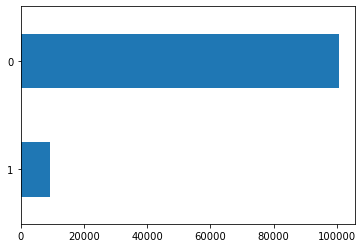

In [96]:
# Посмотрим, сколько у нас всего дефолтных и недефолтных клиентов.
data['default'].value_counts(ascending=True).plot(kind='barh')

**Наблюдается явный дисбаланс классов. Это нужно будет учесть при обучении модели.**

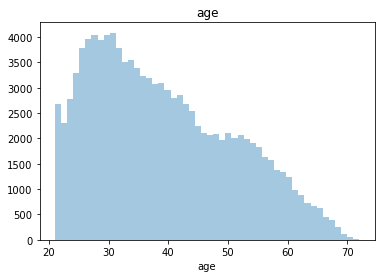

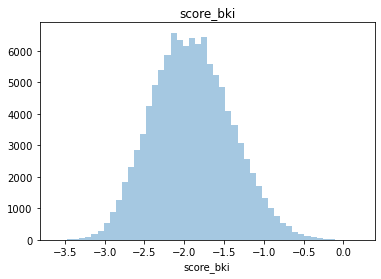

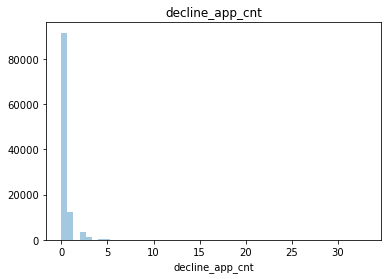

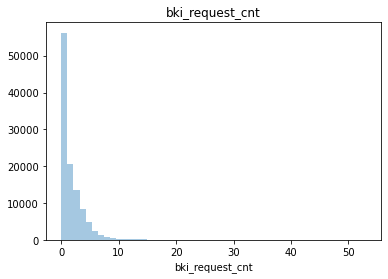

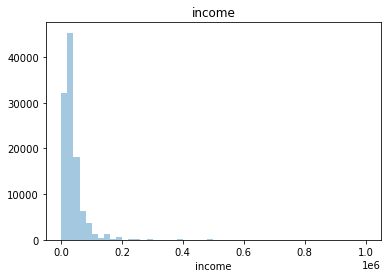

In [94]:
# Нарисуем графики непрерывных признаков
for i in ['age','score_bki','decline_app_cnt','bki_request_cnt','income']:
    plt.figure()
    sns.distplot(data[i].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [95]:
# Сразу прологарифмируем признаки, у которых "тяжелый" правый хвост
data['decline_app_cnt']=data['decline_app_cnt'].apply(lambda x: np.log(x+1))
data['bki_request_cnt']=data['bki_request_cnt'].apply(lambda x: np.log(x+1))
data['income']=data['income'].apply(lambda x: np.log(x+1))

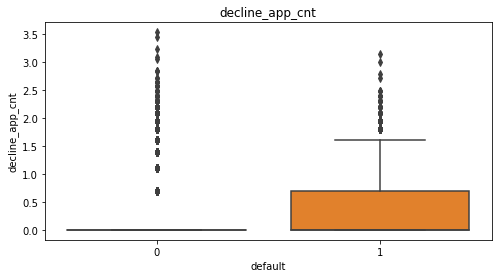

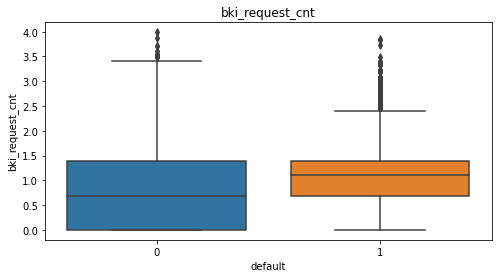

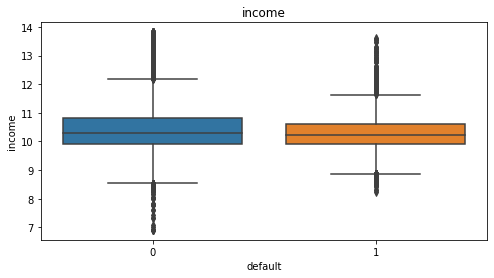

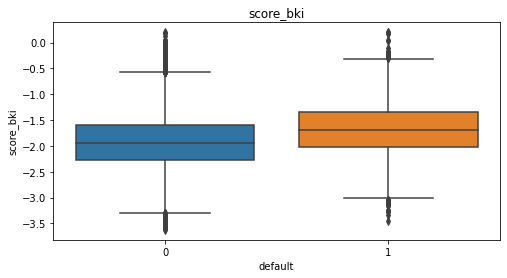

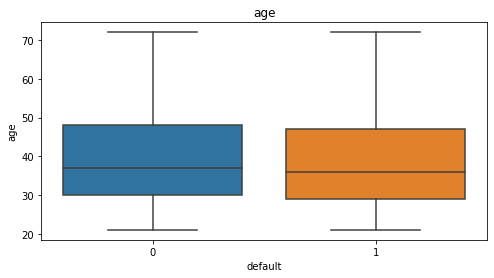

In [99]:
# Нарисуем boxplot для непрерывных переменных (отдельно для дефолтных и для недефолтных клиентов)
for i in ['decline_app_cnt','bki_request_cnt','income', 'score_bki','age']:
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot1 = sns.boxplot(x=data["default"], y=data[i], data=data,ax=ax)
    plt.title(i)

**Мы видим, что очень много точек определено как выбросы. Попробуем с этим разобраться.**

## Работа с выбросами

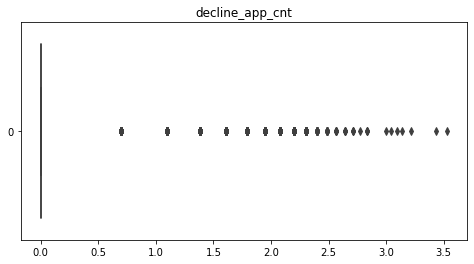

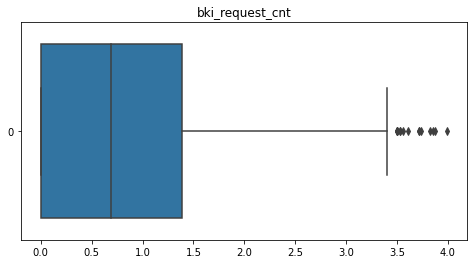

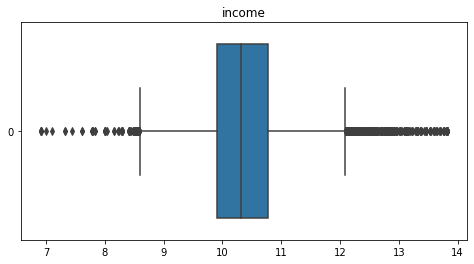

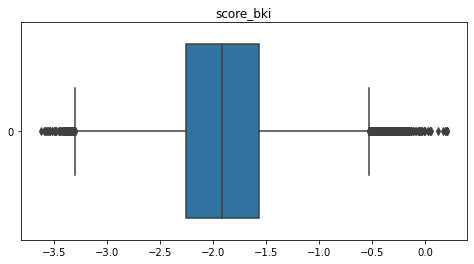

In [100]:
# Теперь нарисуем те же графики для обоих типов клиентов, чтобы понять, что делать с выбросами (и выбросы ли это вообще).
for i in ['decline_app_cnt','bki_request_cnt','income', 'score_bki']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data[i], orient="h")
    plt.title(i)
    plt.show()

In [101]:
# Функция для поиска выбросов в данных методом IQR
def IQR_outliers(i):
    Q1=data[i].quantile(0.25)
    Q3=data[i].quantile(0.75)
    IQR=Q3-Q1
    low=Q1-1.5*IQR
    high=Q3+1.5*IQR
    return (low,high)

In [103]:
# Посчитаем количество выбросов в колонках
count_outliers=[]
percent_outliers=[]
for j in ['score_bki', 'bki_request_cnt', 'income','decline_app_cnt']:
    borders=IQR_outliers(j)
#     print(j,':',borders)
    count=0
    for i in range(0,len(data)):
        if data[j][i]<borders[0] or data[j][i]>borders[1]:
            count+=1
    percent=(count/data.shape[0])*100
    print("В колонке {} содержится {} выбросов, что составляет {:.2f} процентов".format(j,count,percent))
    count_outliers.append(count)
    percent_outliers.append(percent)
print("Количество выбросов в рассмотренных колонках {}".format(count_outliers))
print("Процент выбросов в рассмотренных колонках {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(percent_outliers[0], percent_outliers[1],
                                                                                      percent_outliers[2], percent_outliers[3]))

В колонке score_bki содержится 518 выбросов, что составляет 0.47 процентов
В колонке bki_request_cnt содержится 15 выбросов, что составляет 0.01 процентов
В колонке income содержится 2609 выбросов, что составляет 2.37 процентов
В колонке decline_app_cnt содержится 18677 выбросов, что составляет 16.96 процентов
Количество выбросов в рассмотренных колонках [518, 15, 2609, 18677]
Процент выбросов в рассмотренных колонках 0.47, 0.01, 2.37,16.96


**Практика показала, что замена выбросов на медиану ухудшает модель. В этой связи я закомментировала кусок кода ниже. Все точки, которые метод IQR определил как выбросы, нужно оставить.**

**В целом, "выбросов" немного. Большой процент "выбросов" в колонке decline_app_cnt объясняется природой этого признака (количество отказов в кредите). БОльшая часть данных в этой колонке - нули (помним, что признак был прологарифмирован). Ненулевое значение по методу IQR считается "выбросом". Но в действительности это не выброс, а очень важное для модели значение.**

In [104]:
# medians=[data['score_bki'].median(),data['bki_request_cnt'].median(),data['income'].median(), data['decline_app_cnt'].median()]
# outliers1=IQR_outliers('score_bki')
# outliers2=IQR_outliers('bki_request_cnt')
# outliers3=IQR_outliers('income')
# outliers4=IQR_outliers('decline_app_cnt')
# borders={'score_bki':outliers1,'bki_request_cnt':outliers2,'income':outliers3,'decline_app_cnt':outliers4}
# data['score_bki']=data['score_bki'].apply(lambda x: medians[0] if x<borders['score_bki'][0] or x>borders['score_bki'][1] else x)
# data['bki_request_cnt']=data['bki_request_cnt'].apply(lambda x: medians[1] if x<borders['bki_request_cnt'][0] or x>borders['bki_request_cnt'][1] else x)
# data['income']=data['income'].apply(lambda x: medians[2] if x<borders['income'][0] or x>borders['income'][1] else x)
# data['decline_app_cnt']=data['decline_app_cnt'].apply(lambda x: medians[3] if x<borders['decline_app_cnt'][0] or x>borders['decline_app_cnt'][1] else x)

## Заполнение пропусков

In [105]:
import random

In [106]:
# Заполним пропуски в колонке education рандомными значениями из уже имеющихся. Практика показала, что эту колонку 
# лучше обрабатывать не с помощью get_dummies, а с помощью OneHotEncoder. Для этого необходимо отсутствие пропусков
prob = data['education'].value_counts(normalize=True)
ind = data[data['education'].isna()==True].index
fill_list = pd.Series(random.choices(prob.index, prob, k=data['education'].isna().sum()))
fill_list.index = ind
data['education']=data['education'].fillna(fill_list)

In [108]:
# Функция, заменяющая строковые значения в колонке education на числа (категории). 
def replace_values(string):
    if string=='SCH':
        return 0
    elif string=='UGR':
        return 1
    elif string=='GRD':
        return 2
    elif string=='PGR':
        return 3
    elif string=='ACD':
        return 4

In [109]:
# Заменим строковые значения в колонке education
data['education']=data['education'].apply(replace_values)

## Обработка призаков и feature engineering

In [110]:
# Переведем дату в формат datetime
data['app_date']=data['app_date'].apply(lambda x: datetime.strptime(x,'%d%b%Y')) 

In [111]:
# Извлечем из даты год, месяц и день
data['app_year']=data['app_date'].apply(lambda x: x.year)
data['app_month']=data['app_date'].apply(lambda x: x.month)
data['app_day']=data['app_date'].apply(lambda x: x.day)
data['app_day_of_week']=data['app_date'].apply(lambda x: x.weekday())

In [112]:
# Введем колонку, содержащую количество дней от первой даты в датасете до даты подачи заявки 
data['timedelta']=data['app_date']-data['app_date'].min()
data['timedelta']=data['timedelta'].apply(lambda x: x.days)


In [113]:
# Создадим два словаря с количеством клиентов каждый день и количеством дефолтных клиентов в этот день
number_of_clients=dict(data.groupby('app_date')['client_id'].count())
dictionary_of_defaults=dict(data.groupby('app_date')['default'].value_counts()[:,1])

In [114]:
# Создадим две дополнительных колонки с количеством клиентов в день и количеством дефолтных клиентов в этот день
data['number_of_clients']=data['app_date'].apply(lambda x: number_of_clients[x])
data['number_of_default']=data['app_date'].apply(lambda x: dictionary_of_defaults[x])

In [115]:
# Посчитаем процент дефолтных клиентов для каждого дня
data['percent_of_default']=(data['number_of_default']/data['number_of_clients'])*100

In [116]:
# Год во всем датасете одинаковый (2014), удалим колонку 
data.drop(columns=['app_year'], axis=1, inplace=True)

In [117]:
# Избавимся от признаков client_id и app_date
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [118]:
# Эксперименты с моделью показали, что удаление колонки age улучшает целевую метрику
data.drop(columns=['age'], inplace=True)

**Попробуем добавить WoE (Weight of Evidence) в качестве отдельного признака для колонок score_bki и sna. Я выбрала именно эти признаки, т.к. они являются самыми значимыми для модели (см. "Значимость переменных" ниже).**

In [14]:
# Функия с сайта listendata.com для расчета параметров WOE и IV для непрерывных и категориальных признаков
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [15]:
# Создадим два вспомогательных датасета с параметрами IV и WOE соответственно
DF_IV,DF_WOE=iv_woe(data,'default')

Information value of client_id is 0.017569
Information value of app_date is 0.033298
Information value of education is 0.065819
Information value of sex is 0.002718
Information value of age is 0.006706
Information value of car is 0.016455
Information value of car_type is 0.031826
Information value of decline_app_cnt is 0.059671
Information value of good_work is 0.017679
Information value of score_bki is 0.250495
Information value of bki_request_cnt is 0.040218
Information value of region_rating is 0.075954
Information value of home_address is 0.073392
Information value of work_address is 0.060667
Information value of income is 0.03665
Information value of sna is 0.120569
Information value of first_time is 0.092315
Information value of foreign_passport is 0.043638
Information value of sample is 3.341787
Information value of app_month is 0.012417
Information value of app_day is 0.001962
Information value of app_day_of_week is 0.001046
Information value of timedelta is 0.017448
Informatio

In [16]:
DF_WOE

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,client_id,"(0.999, 11015.7]",11015,1055,0.112569,9960,0.098833,0.130137,0.001788
1,client_id,"(11015.7, 22030.4]",11015,1064,0.113530,9951,0.098744,0.139536,0.002063
2,client_id,"(22030.4, 33045.1]",11015,994,0.106061,10021,0.099438,0.064473,0.000427
3,client_id,"(33045.1, 44059.8]",11014,941,0.100405,10073,0.099954,0.004503,0.000002
4,client_id,"(44059.8, 55074.5]",11015,986,0.105207,10029,0.099518,0.055594,0.000316
...,...,...,...,...,...,...,...,...,...
5,percent_of_default,"(8.687, 8.969]",10025,884,0.094324,9141,0.090706,0.039106,0.000141
6,percent_of_default,"(8.969, 9.161]",11366,1033,0.110222,10333,0.102534,0.072298,0.000556
7,percent_of_default,"(9.161, 9.483]",10878,1017,0.108515,9861,0.097851,0.103443,0.001103
8,percent_of_default,"(9.483, 10.072]",11098,1081,0.115344,10017,0.099399,0.148777,0.002372


In [17]:
# Создадим вспомогательный словарь для добавления признака WOE для колонки sna в основной датасет
dict_of_woe_sna=dict(DF_WOE[DF_WOE['Variable']=='sna']['WoE'])

In [18]:
# Создадим вспомогательный словарь для добавления признака WOE для колонки score_bki в основной датасет
dict_of_woe_score_bki=dict(DF_WOE[DF_WOE['Variable']=='score_bki']['WoE'])
dict_of_cut_off_score_bki=dict(DF_WOE[DF_WOE['Variable']=='score_bki']['Cutoff'])

In [19]:
# Функция для добавления параметрa WOE для колонки sna в основной датасет
def add_woe_sna(n):
    if n==1:
        return dict_of_woe_sna[0]
    elif n==2:
        return dict_of_woe_sna[1]
    elif n==3:
        return dict_of_woe_sna[2]
    elif n==4:
        return dict_of_woe_sna[3]

In [20]:
# Функция для добавления параметрa WOE для колонки score_bki в основной датасет
def add_woe_score_bki(k):
    if dict_of_cut_off_score_bki[0].left<=k<=dict_of_cut_off_score_bki[0].right:
        return dict_of_woe_score_bki[0]
    elif dict_of_cut_off_score_bki[1].left<k<=dict_of_cut_off_score_bki[1].right:
        return dict_of_woe_score_bki[1]
    elif dict_of_cut_off_score_bki[2].left<k<=dict_of_cut_off_score_bki[2].right:
        return dict_of_woe_score_bki[2]
    elif dict_of_cut_off_score_bki[3].left<k<=dict_of_cut_off_score_bki[3].right:
        return dict_of_woe_score_bki[3]
    elif dict_of_cut_off_score_bki[4].left<k<=dict_of_cut_off_score_bki[4].right:
        return dict_of_woe_score_bki[4]
    elif dict_of_cut_off_score_bki[5].left<k<=dict_of_cut_off_score_bki[5].right:
        return dict_of_woe_score_bki[5]
    elif dict_of_cut_off_score_bki[6].left<k<=dict_of_cut_off_score_bki[6].right:
        return dict_of_woe_score_bki[6]
    elif dict_of_cut_off_score_bki[7].left<k<=dict_of_cut_off_score_bki[7].right:
        return dict_of_woe_score_bki[7]
    elif dict_of_cut_off_score_bki[8].left<k<=dict_of_cut_off_score_bki[8].right:
        return dict_of_woe_score_bki[8]
    elif dict_of_cut_off_score_bki[9].left<k<=dict_of_cut_off_score_bki[9].right:
        return dict_of_woe_score_bki[9]

**Эксперименты с моделью показали, что добавление признака WoE ухудшает целевую метрику. Поэтому я закомментировала куски кода ниже**

In [44]:
# data['WOE_sna']=data['sna'].apply(add_woe_sna)

In [45]:
# data['WOE_score_bki']=data['score_bki'].apply(add_woe_score_bki)

**Борьба с мультиколлинеарностью**

In [119]:
# Разобьем признаки на непрерывные, категориальные и бинарные
num_cols = ['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income','timedelta','number_of_clients','percent_of_default','number_of_default']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
bin_cols = ['sex','car', 'car_type', 'good_work', 'foreign_passport']

<AxesSubplot:>

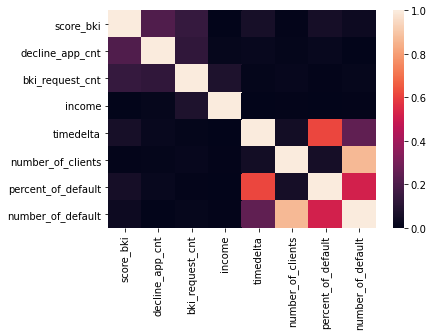

In [120]:
# Построим тепловую карту матрицы корреляций непрерывных признаков. Интересно, что timedelta сильно 
# скореллировано с percent_of_default (коэффициент корреляции -0.62). 
# Это значит, что с течением времени падает число дефолтных клиентов
# Признак number_of_clients сильно скоррелирован с number_of_default (коэффициент корреляции 0.87), а number_of_default сильно 
# скоррелирован с percent_of_default (коэффициент корреляции 0.52). Если использовать все эти признаки, качество модели 
# ухудшается. Можно было бы удалить некоторые из признаков, но вместо этого я использую метод главных
# компонент (PCA).
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

In [121]:
# Строим матрицу корреляций признаков, для которых будем искать главные компоненты
pca_columns=['number_of_clients','number_of_default','percent_of_default']
correlation_matrix=data[pca_columns].corr().values

In [122]:
# Находим собственные числа и собственные вектора
B=np.linalg.eig(correlation_matrix)
B

(array([2.03791266, 0.01055159, 0.95153575]),
 array([[-0.60441574, -0.6084903 , -0.514219  ],
        [-0.6983878 ,  0.71526496, -0.0255051 ],
        [-0.38332244, -0.34370859,  0.8572796 ]]))

In [123]:
# Центрируем и нормируем признаки
mean_1=data['number_of_clients'].mean()
len_1=np.linalg.norm(data['number_of_clients'])
data['number_of_clients']=data['number_of_clients'] - mean_1
data['number_of_clients']=data['number_of_clients']/len_1

mean_2=data['number_of_default'].mean()
len_2=np.linalg.norm(data['number_of_default'])
data['number_of_default']=data['number_of_default'] - mean_2
data['number_of_default']=data['number_of_default']/len_2

mean_3=data['percent_of_default'].mean()
len_3=np.linalg.norm(data['percent_of_default'])
data['percent_of_default']=data['percent_of_default'] - mean_3
data['percent_of_default']=data['percent_of_default']/len_3

In [124]:
# Создаем новый признак
data['pca_component']=B[1][0][0]*data['number_of_clients']+B[1][1][0]*data['number_of_default']+B[1][2][0]*data['percent_of_default']

In [125]:
# Удаляем старые признаки
data.drop(columns=['percent_of_default','number_of_default','number_of_clients'],axis=1,inplace=True)

In [129]:
# Применим Label_Encoder для бинарных признаков

# binary_cols = ['sex','car', 'car_type', 'good_work', 'foreign_passport']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# ohe=preprocessing.OneHotEncoder(sparse=False)

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
# Для категориальных признаков применим OneHotEncoder. Сделаем это чуть позже

**Попробуем добавить полиномиальные признаки**

In [126]:
from sklearn.model_selection import train_test_split

In [52]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [53]:
from itertools import combinations

In [127]:
# Функция для подбора наилучших полиномиальных признаков. Будем комбиринровать колонки с непрерывным
# типом данных по три штуки и создавать на их основе Polynomial Features степени 2, а затем обучать модель с этими признаками.
# Наилучшая комбинация признаков вернет максимальное значение метрики f1_score.
def find_polynomial_features(df,cols):
    pf=PolynomialFeatures(2)
    poly_features=pf.fit_transform(df[cols])
    index=df.index
    right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
    right.drop(columns=['1','2','3','4'], inplace=True)
    df=df.join(right, how='inner')
    
    train_data = df.query('sample == 1').drop(['sample'], axis=1)
#     test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)
    y = train_data['default'].values  # наш таргет
    X = train_data.drop(['default'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X1=X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10']].values
    X2=X_test[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10']].values
    
    scaler=RobustScaler()
    X1_transformed=scaler.fit_transform(X1)
    X2_transformed=scaler.transform(X2)
    X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
    X_test[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10']]=X2_transformed
    
    model = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', penalty='l2', tol=0.001, multi_class='ovr')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) 
    return metrics.f1_score(y_test,y_pred)

In [47]:
from sklearn.preprocessing import PolynomialFeatures

In [130]:
# Запустим цикл, который перебирает комбинации непрерывных признаков по 3 и ищет среди них наилучшую комбинацию.
columns=['decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'timedelta','pca_component']
cand=find_polynomial_features(data,['decline_app_cnt', 'score_bki','bki_request_cnt'])
columns_best=['decline_app_cnt', 'score_bki','bki_request_cnt']
for i in combinations(columns,3):    
    f1_score_current=find_polynomial_features(data,list(i))
    print('For the following columns: ',i,' f1_score=', f1_score_current,'\n')
    if f1_score_current>cand:
        cand=f1_score_current
        columns_best=i
print(cand)
print(columns_best)

<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'score_bki', 'bki_request_cnt')  f1_score= 0.3375390042056709 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'score_bki', 'income')  f1_score= 0.3368306308761411 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'score_bki', 'timedelta')  f1_score= 0.3374797187669011 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'score_bki', 'pca_component')  f1_score= 0.3365070729053319 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'bki_request_cnt', 'income')  f1_score= 0.33807829181494664 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'bki_request_cnt', 'timedelta')  f1_score= 0.33803975325565455 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'bki_request_cnt', 'pca_component')  f1_score= 0.3384741367544698 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'income', 'timedelta')  f1_score= 0.3378895571350465 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'income', 'pca_component')  f1_score= 0.3386301369863014 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('decline_app_cnt', 'timedelta', 'pca_component')  f1_score= 0.3387933387933388 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'bki_request_cnt', 'income')  f1_score= 0.3377510588878262 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'bki_request_cnt', 'timedelta')  f1_score= 0.3386286490156144 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'bki_request_cnt', 'pca_component')  f1_score= 0.33828135639384443 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'income', 'timedelta')  f1_score= 0.33868335146898804 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'income', 'pca_component')  f1_score= 0.33875153667531754 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('score_bki', 'timedelta', 'pca_component')  f1_score= 0.33909375425227917 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('bki_request_cnt', 'income', 'timedelta')  f1_score= 0.33833970507919164 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('bki_request_cnt', 'income', 'pca_component')  f1_score= 0.3375342465753425 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('bki_request_cnt', 'timedelta', 'pca_component')  f1_score= 0.3381629305631493 



<ipython-input-127-11368395b9ea>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta','5','6','7','8','9','10' ]]=X1_transformed
C:\Users\Sasha\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-127-11368395b9ea>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

For the following columns:  ('income', 'timedelta', 'pca_component')  f1_score= 0.33797814207650273 

0.33909375425227917
('score_bki', 'timedelta', 'pca_component')


**Найдена наилучшая комбинация колонок с непрерывными признаками (score_bki, timedelta, pca_component). Однако, практика показала, что добавление таких полиномиальных признаков ухудшает целевую метрику. Поэтому я закомментировала кусок кода ниже.**

**Я также исследовала полиномиальные признаки, сделанные вручную. Некоторые такие полиномиальные признаки улучшают качество модели, поэтому было решено их оставить.**

In [131]:
# pf=PolynomialFeatures(2)
# poly_features=pf.fit_transform(data[['score_bki','timedelta','pca_component']])

# index=data.index
# right=pd.DataFrame(poly_features, columns=['1','2','3','4','5','6','7','8','9','10'], index=index)
# data=data.join(right, how='inner')
# data.drop(columns=['1','2','3','4','6','7','8','9','10'], inplace=True)

In [132]:
# Попробуем сделать Polynomial Features  вручную
# Некоторые полиномиальные признаки ухудшают модель, поэтому я закомментировала определенные куски кода.
data['n1']=data['decline_app_cnt']*data['bki_request_cnt']*data['score_bki']
# data['n2']=data['decline_app_cnt']**2 + data['bki_request_cnt']*data['score_bki']
# data['n3']=data['decline_app_cnt']*data['bki_request_cnt'] + data['score_bki']**2
# data['n4']=data['decline_app_cnt']*data['score_bki'] + data['bki_request_cnt']**2
# data['n5']=data['decline_app_cnt']**2 + data['score_bki']**2 + data['bki_request_cnt']**2

# data['n6']=data['home_address']**2 - data['work_address']*data['region_rating']
# data['n7']=data['region_rating']**2 - data['home_address']*data['work_address']
# data['n8']=data['work_address']**2 - data['home_address']*data['region_rating']

data['n9']=data['sna']*data['first_time']
data['n10']=data['sna'] - data['first_time']


# data['n11']=data['income']/data['region_rating']
# data['n12']=data['timedelta']/data['first_time']

<AxesSubplot:>

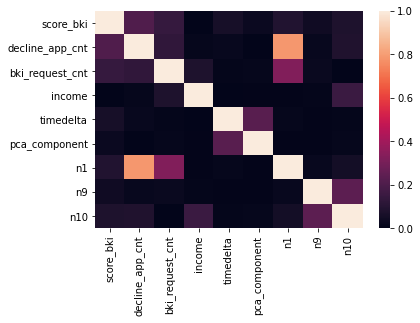

In [133]:
# Проверим, есть ли скоррелированность между новыми полиномиальными признаками
poly_columns=['score_bki','decline_app_cnt', 'bki_request_cnt','income','timedelta', 'pca_component','n1','n9','n10']
sns.heatmap(data[poly_columns].corr().abs(), vmin=0, vmax=1)

**Скоррелированности между новыми полиномиальными признаками нет**

## Значимость признаков для модели

In [134]:
from sklearn.feature_selection import f_classif

<AxesSubplot:>

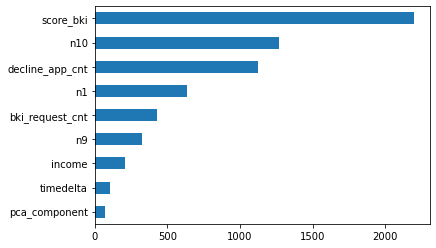

In [135]:
# Самым важным среди непрерывных признаков является score_bki
cols=['score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income','timedelta','pca_component', 'n1','n9','n10']
imp_num = pd.Series(f_classif(data[cols], data['default'])[0], index = cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [136]:
from sklearn.feature_selection import mutual_info_classif

<AxesSubplot:>

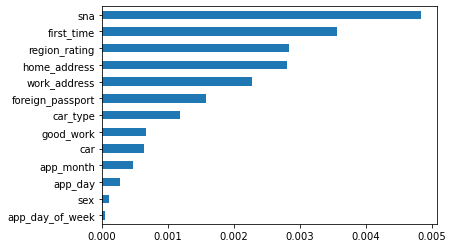

In [137]:
# Самым важным среди категориальных и бинарных признаков является sna
other_cols = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'app_day_of_week']

imp_cat = pd.Series(mutual_info_classif(data[other_cols], data['default'],
                                     discrete_features =True), index = other_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

## Подготовка данных к загрузке в модель

In [138]:
# Разделим датасет снова на тест и трейн
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

In [100]:
from sklearn.model_selection import StratifiedShuffleSplit

**Я попробовала использовать стратифицированное разбиение выборки. Это не привело к улучшению результата. Поэтому было принято решение пользоваться разбиением train_test_split.**

In [63]:
# Этот кусок кода закомментирован, т.к. применение StratifiedShuffleSplit не приводит к улучшению результата.
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
# train_indices, valid_indices = [split for split in sss.split(train_data.drop(['default'],axis=1), train_data['default'])][0]

# X1=train_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']].values
# X2=test_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']].values

# scaler=RobustScaler()
# X1_transformed=scaler.fit_transform(X1)
# X2_transformed=scaler.transform(X2)

# train_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']]=X1_transformed
# test_data[['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']]=X2_transformed

# s_train = train_data.iloc[train_indices]
# s_valid = train_data.iloc[valid_indices]

# numeric_cols=['age','decline_app_cnt','bki_request_cnt','income', 'score_bki','pca_component','timedelta']

# from sklearn.preprocessing import OneHotEncoder

# columns = ['education','first_time', 'sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
# ohe_train_train=OneHotEncoder(sparse=False)
# X_cat_train_train = ohe_train_train.fit_transform(s_train[columns].values)

# ohe_train_test=OneHotEncoder(sparse=False)
# X_cat_train_test = ohe_train_test.fit_transform(s_valid[columns].values)

# ohe_test=OneHotEncoder(sparse=False)
# X_cat_test=ohe_test.fit_transform(test_data[columns].values)

# X_train=np.hstack([s_train[numeric_cols].values, s_train[bin_cols].values, X_cat_train_train])
# X_test=np.hstack([s_valid[numeric_cols].values, s_valid[bin_cols].values, X_cat_train_test])

# y_train=s_train['default'].values
# y_test=s_valid['default'].values

# X_train=pd.DataFrame(X_train, columns=[i for i in range(0,80)], index=[j for j in range(0,59039)])
# X_test=pd.DataFrame(X_test, columns=[i for i in range(0,80)], index=[j for j in range(0,14760)])
# X=X_train.append(X_test,sort=False).reset_index(drop=True)

# y_train=pd.DataFrame(y_train, columns=['0'], index=[j for j in range(0,59039)])
# y_test=pd.DataFrame(y_test, columns=['0'], index=[j for j in range(0,14760)])
# y=y_train.append(y_test,sort=False).reset_index(drop=True)

# X_valid=np.hstack([X2_transformed,test_data[bin_cols], X_cat_test])

In [139]:
# Проведем обработку категориальных признаков отдельно в test и train. Используем для этого 
# OneHotEncoder. Практика показала, что это дает увеличение целевой метрики по сравнению с 
# использованием необработанных категориальных признаков.

from sklearn.preprocessing import OneHotEncoder

columns = ['education','first_time','sna', 'work_address', 'home_address', 'region_rating','app_day','app_month','app_day_of_week']
ohe_train=OneHotEncoder(sparse=False)
X_cat_train = ohe_train.fit_transform(train_data[columns].values)

ohe_test=OneHotEncoder(sparse=False)
X_cat_test=ohe_test.fit_transform(test_data[columns].values)

In [140]:
# Обработаем по отдельности колонки c непрерывным типом данных из train и test
X1=train_data[['decline_app_cnt','bki_request_cnt','income','score_bki', 'timedelta','pca_component','n1','n9','n10']].values
X2=test_data[['decline_app_cnt','bki_request_cnt','income','score_bki', 'timedelta','pca_component','n1','n9','n10']].values

# Пропустим через RobustScaler все колонки с непрерывным типом данных. Я выбрала RobustScaler, потому что
# он нечувствителен к выбросам и дает лучший результат в Kaggle, чем StandardScaler. 
# Обработаем отдельно колонки из test и train
scaler=RobustScaler()
X1_transformed=scaler.fit_transform(X1)
X2_transformed=scaler.transform(X2)

# Запишем в датасет нормализованные значения колонок
train_data[['decline_app_cnt','bki_request_cnt','income','score_bki', 'timedelta','pca_component','n1','n9','n10']]=X1_transformed
test_data[['decline_app_cnt','bki_request_cnt','income','score_bki', 'timedelta','pca_component','n1','n9','n10']]=X2_transformed

In [141]:
# Составим матрицу независимых переменных для train и валидации
X=np.hstack([X1_transformed, train_data[bin_cols].values, X_cat_train])
X_valid=np.hstack([X2_transformed,test_data[bin_cols], X_cat_test])

In [142]:
y = train_data['default'].values  # наш таргет

In [143]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 82), (14760, 82), (59039,), (14760,))

## Применение модели логистической регрессии

**По условию задачи можно пользоваться только логистической регрессией. Другие модели использовать нельзя. Параметры логистической регрессии разрешается подбирать.**

In [145]:
# Обучим логистическую регрессию с параметрами по умолчанию
logreg_basic=LogisticRegression()

logreg_basic.fit(X_train, y_train)
y_pred = logreg_basic.predict(X_test) 
Y_pred=logreg_basic.predict(X_train)
y_pred_proba=logreg_basic.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
Y_pred_proba=logreg_basic.predict_proba(X_train)
Y_pred_proba=Y_pred_proba[:,1]

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [146]:
# Импортируем все необходимые метрики
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, roc_auc_score, recall_score, confusion_matrix

In [147]:
# Напишем функцию, которая будет отображать нам значения всех метрик на тренировочной выборке и на тестовой
def show_metrics(y_pred_train, Y_train, y_pred_test, Y_test, y_pred_proba_train, y_pred_proba_test):
    f1_score_train=f1_score(y_pred_train,Y_train)
    f1_score_test=f1_score(y_pred_test,Y_test)
    print('[train] f1_score {0:.2f}, [test] f1_score {1:.2f}\n'.format(f1_score_train,f1_score_test))
    precision_score_train=precision_score(y_pred_train,Y_train)
    precision_score_test=precision_score(y_pred_test,Y_test)
    print('[train] precision_score {0:.2f}, [test] precision_score {1:.2f}\n'.format(precision_score_train,precision_score_test))
    recall_score_train=recall_score(y_pred_train,Y_train)
    recall_score_test=recall_score(y_pred_test,Y_test)
    print('[train] recall_score {0:.2f}, [test] recall_score {1:.2f}\n'.format(recall_score_train,recall_score_test))
    accuracy_score_train=accuracy_score(y_pred_train,Y_train)
    accuracy_score_test=accuracy_score(y_pred_test,Y_test)
    print('[train] accuracy_score {0:.2f}, [test] accuracy_score {1:.2f}\n'.format(accuracy_score_train,accuracy_score_test))
    roc_auc_score_train=roc_auc_score(Y_train,y_pred_proba_train)
    roc_auc_score_test=roc_auc_score(Y_test,y_pred_proba_test)
    print('[train] roc_auc_score {0:.2f}, [test] roc_auc_score {1:.2f}\n'.format(roc_auc_score_train,roc_auc_score_test))
    confusion_matrix_train=confusion_matrix(y_pred_train,Y_train)
    confusion_matrix_test=confusion_matrix(y_pred_test,Y_test)
    print('[train] confusion_matrix \n {0}, \n[test] confusion_matrix \n {1}\n'.format(confusion_matrix_train,confusion_matrix_test))

In [148]:
# Выведем метрики
show_metrics(Y_pred,y_train,y_pred,y_test,Y_pred_proba,y_pred_proba)

[train] f1_score 0.07, [test] f1_score 0.05

[train] precision_score 0.03, [test] precision_score 0.03

[train] recall_score 0.50, [test] recall_score 0.43

[train] accuracy_score 0.87, [test] accuracy_score 0.88

[train] roc_auc_score 0.74, [test] roc_auc_score 0.74

[train] confusion_matrix 
 [[51234  7282]
 [  260   263]], 
[test] confusion_matrix 
 [[12869  1778]
 [   64    49]]



In [149]:
# Функция, визуализирующая усредненную метрику на кросс-валидации
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

In [150]:
from sklearn.model_selection import cross_validate
cv_metrics = cross_validate(logreg_basic, X, y, cv=5, scoring='f1', return_train_score=True)

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[train] F1-score = 0.06 +/- 0.00
[valid] F1-score = 0.06 +/- 0.00


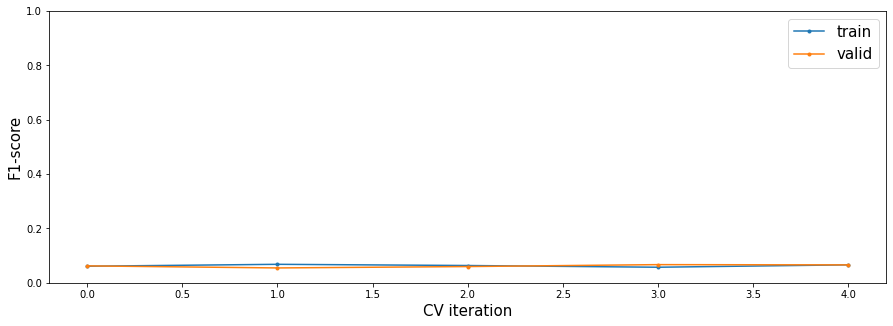

In [151]:
# Видим, что переобучения нет
plot_cv_metrics(cv_metrics)

**Видим, что логистическая регрессия с параметрами по умолчанию показала очень плохой результат. Значение метрики f1_score на кросс-валидации равно всего 0.06. Попробуем подобрать оптимальные параметры логистической регрессии, возможно, это улучшит результат.**

### Подбор параметров логистической регрессии

In [152]:
from sklearn.model_selection import GridSearchCV

In [153]:
# Запутим подбор параметров модели с помощью GridSearchCV
model=LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [   {'penalty': ['l1'], 
      'solver': ['liblinear', 'saga'], 
      'class_weight':['none', 'balanced'], 
      'multi_class': ['auto','ovr'], 
      'max_iter':[iter_],
      'tol':[epsilon_stop]},
     {'penalty': ['l2'], 
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
      'class_weight':['none', 'balanced'], 
      'multi_class': ['auto','ovr'], 
      'max_iter':[iter_],
      'tol':[epsilon_stop]},
     {'penalty': ['none'], 
      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
      'class_weight':['none', 'balanced'], 
      'multi_class': ['auto','ovr'], 
      'max_iter':[iter_],
      'tol':[epsilon_stop]}, ]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.06440401        nan 0.06440401 0.34140278 0.34156239
 0.34136996 0.34156239 0.06487192 0.06487581        nan 0.06511326
 0.06511326 0.06487192 0.06487581        nan 0.06511326 0.06511326
 0.34128023 0.3415736  0.34126824 0.34135979 0.34125662 0.34128023
 0.3415736  0.34126824 0.34132203 0.34126824 0.06511326 0.06486518
 0.06511326 0.06511326 0.06511326 0.06486518 0.06511326 0.06511326
 0.34117441 0.34120094 0.34132239 0.34117441 0.34117441 0.34120094
 0.34116425 0.34117441]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


C:\Users\Sasha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Вот найденные методом GridSearchCV оптимальные параметры модели:**
* C: 1.0 (по умолчанию)
* class_weight: 'balanced' (подобрано, по умолчанию None)
* dual: False (по умолчанию)
* fit_intercept: True (по умолчанию)
* intercept_scaling: 1 (по умолчанию)
* l1_ratio: None (по умолчанию)
* max_iter: 50 (установлено нами)
* multi_class: 'auto' (по умолчанию)
* n_jobs: None (по умолчанию)
* penalty: 'l2' (по умолчанию)
* random_state: None (по умолчанию)
* solver: 'lbfgs' (по умолчанию)
* tol: 0.001 (установлено нами, по умолчанию 0.0001)
* verbose: 0 (по умолчанию)
* warm_start: False (по умолчанию)

**Отдельно подберем гиперпараметр С**

In [154]:
C_list =np.arange(0.01, 1.01, 0.01)
max_f1 = -1
max_C = -1
for c in C_list:
    model = LogisticRegression(max_iter=1000, class_weight='balanced', tol=0.001, C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    if f1 > max_f1:
        max_f1 = f1
        max_C= c
print(max_C, max_f1)

0.01 0.3408624229979466


In [155]:
# Создадим модель в оптимальными параметрами, найденными с помощью инструмента GridSearchCV и приведенного выше цикла.
# Единственное, что я изменила - это количество итераций. GridSearchCV каждый раз запускался с количеством итераций 50. 
# Я изменила это число на 1000 в итоговой модели. Это дает лучший результат.
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.01, tol=0.001)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test) 
Y_pred=logreg.predict(X_train)
y_pred_proba=logreg.predict_proba(X_test)
y_pred_proba=y_pred_proba[:,1]
Y_pred_proba=logreg.predict_proba(X_train)
Y_pred_proba=Y_pred_proba[:,1]

In [156]:
# Выведем метрики
show_metrics(Y_pred,y_train,y_pred,y_test,Y_pred_proba,y_pred_proba)

[train] f1_score 0.34, [test] f1_score 0.34

[train] precision_score 0.67, [test] precision_score 0.68

[train] recall_score 0.23, [test] recall_score 0.23

[train] accuracy_score 0.67, [test] accuracy_score 0.67

[train] roc_auc_score 0.74, [test] roc_auc_score 0.74

[train] confusion_matrix 
 [[34642  2493]
 [16852  5052]], 
[test] confusion_matrix 
 [[8700  582]
 [4233 1245]]



In [157]:
cv_metrics = cross_validate(logreg, X, y, cv=5, scoring='f1', return_train_score=True)

[train] F1-score = 0.34 +/- 0.00
[valid] F1-score = 0.34 +/- 0.01


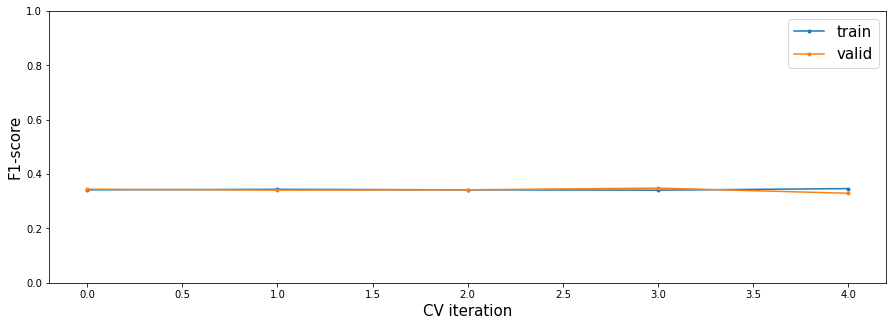

In [158]:
plot_cv_metrics(cv_metrics)

**Как видно из результатов кросс-валидации, логистическая регрессия с оптимизированными параметрами дает гораздо лучший результат. Значение метрики f1_score равно 0.34.**

## Выводы

**1. Разведывательный анализ данных показал, что данные достаточно чистые. Пропусков немного (только в колонке education). Пропуски в колонке education были заполнены случайными значениями из уже существующих.**

**2. Колонки в датасете делятся на бинарные, категориальные и с непрерывным типом данных. Бинарные колонки были обработаны с помощью LabelEncoder, категориальные - с помощью OneHotEncoder.**

**3. Некоторые колонки с непрерывным типом данных ('decline_app_cnt', 'bki_request_cnt', 'income') имеют "тяжелый" правый хвост. Это колонки были прологарифмированы. Операция была проведена над объединенным датасетом (трейн + тест).**

**4. Были сгенерированы дополнительные непрерывные признаки (4 колонки) и категориальные признаки (3 колонки). Новые категориальные признаки повышают качество модели. Новые непрерывные признаки сильно скоррелированы, поэтому их использование ухудшает качество модели. Три наиболее скоррелированных признака были обработаны методом главных компонент. Это дало улучшение целевой метрики.**

**5. Работа с выбросами в данном датасете не принесла улучшения качества модели. Выбросы были классифицированы методом IQR (фактически это не выбросы, а просто отличающиеся значения в датасете). Т.к. удаление "выбросов" приводит к ухудшению качества модели, "выбросы" было решено оставить.**

**6. Была предпринята попытка сгенерировать полиномиальные признаки (вручную и с помощью функции Polynomial Features). Некоторые полиномиальные признаки помогают улучшить целевую метрику, а некоторые, наоборот, ухудшают. Были оставлены только признаки, помогающие улучшить модель.**

**7. Наибольшее значение для модели имеют признаки score_bki и sna.**

**8. Было испробовано добавление параметра WоE для наиболее значимых признаков score_bki и sna (сначала в качестве дополнительного признака, а потом с заменой исходных признаков). Это не принесло улучшения качества модели.**

**9. Удаление наименее значимого непрерывного признака age улучшает целевую метрику.** 

**10. Было испробовано деление выборки на обучающую и тестовую с помощью StratifiedShuffleSplit (деление на части с учетом долей классов). Это не дало увеличения целевой метрики. От данного способа деления выборки было принято решение отказаться в пользу train_test_split.**

**11. С помощью метода GridSerchCV были подобраны оптимальные параметры для модели логистической регрессии. От значений по умолчанию отличается только параметр class_weight ('balanced').**

**12. Был подобран гиперпараметр С=0.01, что соответствует максимальному вкладу регуляризации. Это дало улучшение целевой метрики по сравнению с С=1.0 (значение по умолчанию).**

**13. Использование логистической регрессии с оптимизированными параметрами позволяет получить значение метрики f1_score, равное 0.34. Переобучения модели нет.**

## Сабмишн на каггл

In [125]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', С=0.01, tol=0.001, multi_class='ovr')
logreg_final.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='ovr',
                   solver='saga', tol=0.001)

In [128]:
predict_submission = logreg_final.predict(X_valid)

In [129]:
# Заполняем sample_submission для каггл
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [130]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.374288
std,31706.052195,0.483945
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [131]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
